In [1]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry
from matplotlib import pyplot as plt
import numpy as np

plt.style.use("bmh")
plt.rc("font", size=14)

In [2]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [3]:
# Coordinates of Iowa State University (as example)
lat = 42.02706
long = -93.65288

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": lat,
    "longitude": long,
    "start_date": "2025-02-10",
    "end_date": "2025-02-20",
    "hourly": ["temperature_2m", "relative_humidity_2m", "precipitation"],
    "temperature_unit": "fahrenheit",
    "wind_speed_unit": "kn",
    "timeformat": "unixtime"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

Coordinates 42.00351333618164°N -93.66812133789062°E
Elevation 292.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


In [4]:

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(2).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
    start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
    end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
    freq = pd.Timedelta(seconds = hourly.Interval()),
    inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["precipitation"] = hourly_precipitation

ts = np.arange(hourly.Time(), hourly.TimeEnd(), hourly.Interval())
df = pd.DataFrame(data = hourly_data, index = pd.to_datetime(ts, unit="s"))



Text(0, 0.5, 'temperature (°F)')

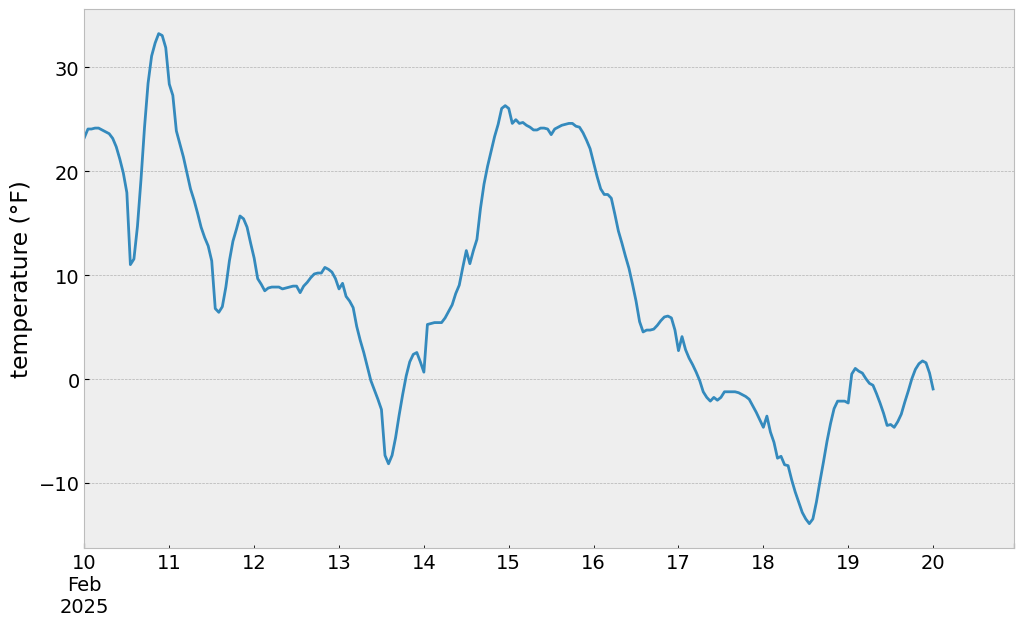

In [5]:
fig = plt.figure(figsize=(12, 7))
df.temperature_2m.plot()
plt.ylabel("temperature (°F)")